# California Housing

Much of data analysis with ML is in the data preparation step: building monitoring tools, setting up human evaluation pipelines, and automating regular model training. The machine learning algorithms are important, of course, but it is probably preferable to be comfortable with the overall process and know three or four algorithms well rather than to spend all your time exploring advanced algorithms.

Let's analyze how housing prices across California varies according to a number of factors.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Getting Data

In [2]:
HOUSING_FILE = "../data/ca_housing.csv"
if not Path(HOUSING_FILE).exists():
    print(f"ERROR: {HOUSING_FILE} does not exist")
else:
    raw = pd.read_csv(HOUSING_FILE)
    
raw.shape

(20640, 10)

## Checking out Data

In [3]:
raw.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
raw.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [6]:
raw.value_counts("ocean_proximity")

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
dtype: int64

## Data Visualization

In [7]:
import matplotlib.pyplot as plt

def saveImage(filename, format="png", dpi=300):
    plt.savefig(f"ca_housing_histograms.{format}", format=format, dpi=dpi)
    
plt.rc('font', size=12)
plt.rc('axes', labelsize=12, titlesize=12)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

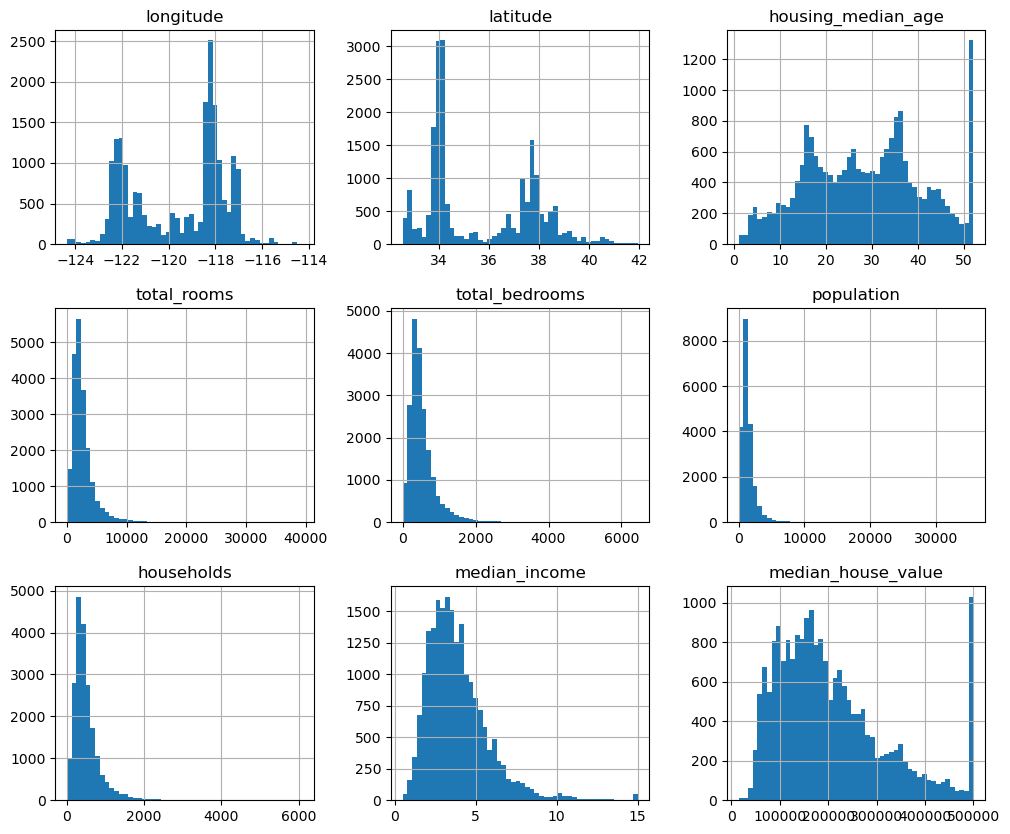

In [8]:
housing = raw.copy()

housing.hist(bins=50, figsize=(12, 10))

# saving the image to a file
saveImage(f"ca_housing_histograms")
plt.show()

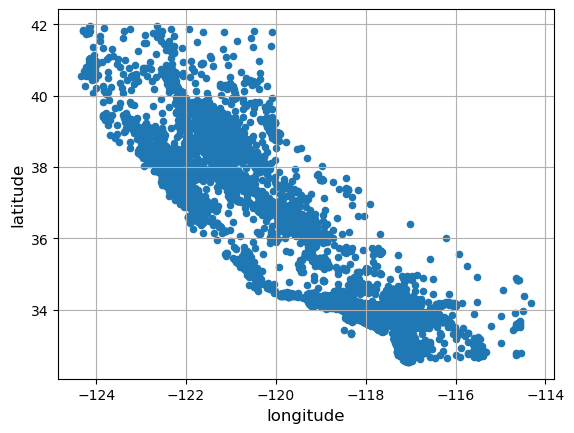

In [9]:
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             grid=True)
saveImage(f"ca_housing_map1")
plt.show()

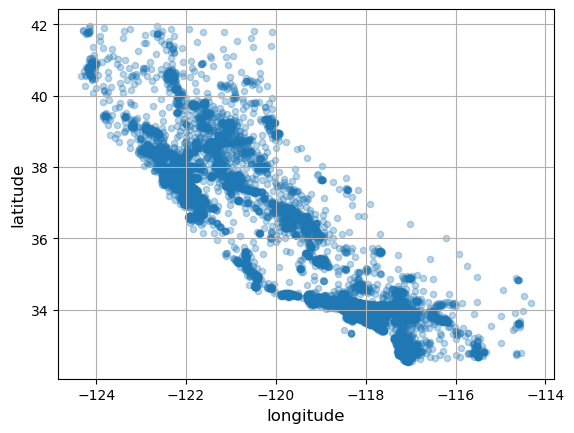

In [10]:
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             grid=True, 
             alpha=0.3)
saveImage(f"ca_housing_map2")
plt.show()

`matplotlib` ColorMap: [link](https://matplotlib.org/stable/tutorials/colors/colormaps.html) main choices:
- rainbow
- jet
- turbo

DataFrame parameters:
- "kind" : type of graph
- "s" : size of bubble
- "c" : color variable

In [ ]:
housing.columns

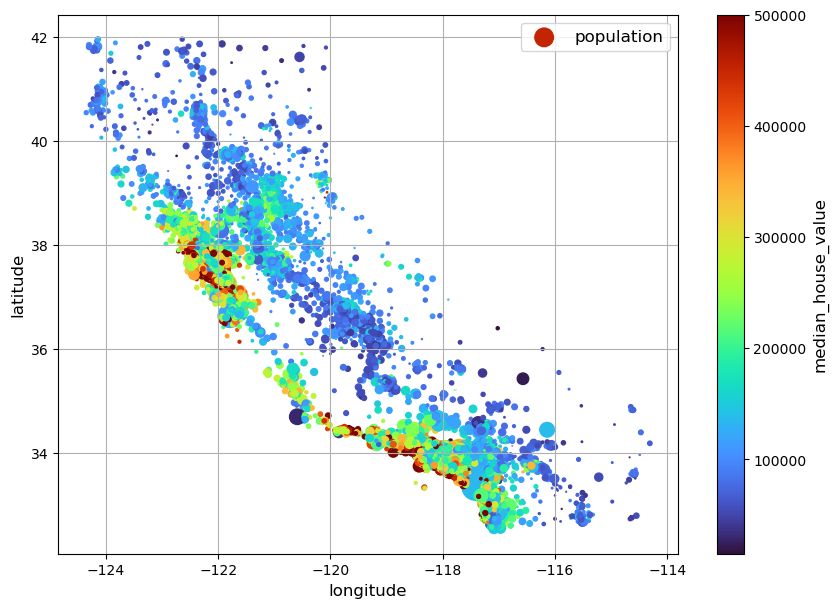

In [11]:
housing.plot(kind="scatter", 
             x="longitude", 
             y="latitude", 
             grid=True,
             s=housing["population"] / 100, 
             label="population",
             c="median_house_value", 
             cmap="turbo", 
             colorbar=True,
             legend=True, 
             figsize=(10, 7))
saveImage("ca_housing_map3")  # extra code
plt.show()

## Stratified Sampling

Stratified random sampling is a technique used to ensure that the training and test datasets represent the overall population. This technique is especially important when you're dealing with an imbalanced dataset, or when the dataset's categorical variables have different levels with varying frequencies.

In a stratified random sample, each subgroup within the overall population is adequately represented within the whole sample. Each subgroup is called a stratum, and stratified random sampling represents these strata well.

Let's say you've talked with some professionals and they've explained that the middle (or median) income level is really important for predicting the average price of houses. You would want to make sure that your test data represents the different ranges of income in all your information.

Since the median income is just a plain number and could be anything, we first need to create income categories. Imagine we look at our data's median incomes. You'll notice that most of the median income levels are bunched up between $15,000 to $60,000. But, some median incomes are much higher than that.

To get a good estimate of the importance of each income level (or stratum), we need to have enough data for each level. This means we shouldn't have too many different income categories, and each category should include a good amount of data.

So, how can we do this? Well, we can use something called the pd.cut() function to make an income category with five groups (numbered from 1 to 5). The first group ranges from 0 to 1.5 (or less than $15,000), the second group from 1.5 to 3, and so on. This way, we can ensure each group has enough data and isn't too specific.

<Axes: >

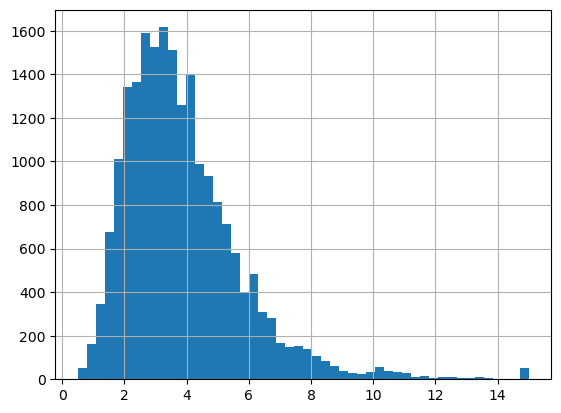

In [15]:
housing["median_income"].hist(bins=50)

In [17]:
pd.options.mode.chained_assignment = None  # default='warn'
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [18]:
housing['income_cat'].value_counts().sort_index()

1     822
2    6581
3    7236
4    3639
5    2362
Name: income_cat, dtype: int64

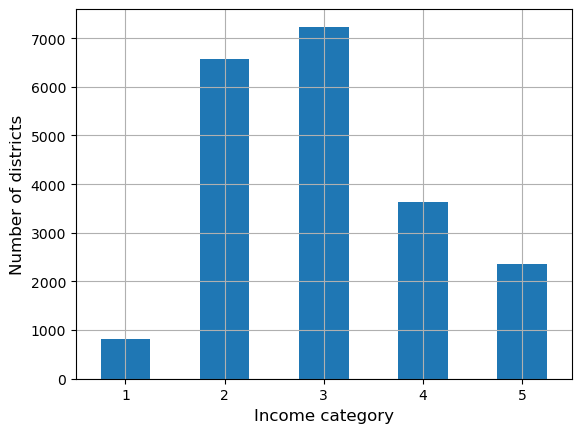

In [19]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

Scikit-learn provides several functions to split datasets, such as train_test_split(). 

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
housing.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [23]:
strat_train_set, strat_test_set = train_test_split(
    housing, 
    test_size=0.2, 
    stratify=housing["income_cat"], 
    random_state=1)

In [24]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [25]:
# random train_test split
rand_train_set, rand_test_set = train_test_split(
    housing, 
    test_size=0.2, 
    random_state=1
)

In [26]:
# comparing error differences for random vs stratified sampling

def cat_proportions(df, cat):
    return df[cat].value_counts() / len(df)

compare_df = pd.DataFrame({
    "Target %": cat_proportions(housing, "income_cat"),
    "Random %": cat_proportions(rand_test_set, "income_cat"),
    "Stratified %": cat_proportions(strat_test_set, "income_cat"),
}).sort_index()
compare_df.index.name = "Income Category"
(compare_df*100).round(2)


,Target %,Random %,Stratified %
Income Category,,,
1,3.98,4.24,4.00
2,31.88,31.08,31.88
3,35.06,35.42,35.05
4,17.63,17.47,17.64
5,11.44,11.80,11.43


In [27]:
# after creating the stratified samples, we can remove the "income_cat"

for s in (strat_train_set, strat_test_set):
    s.drop("income_cat", axis=1, inplace=True)

In [28]:
strat_train_set.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
19582,-122.17,37.78,42.0,1524.0,260.0,651.0,267.0,3.6875,157300.0,NEAR BAY
18188,-117.81,33.67,9.0,3279.0,530.0,1447.0,510.0,7.4581,296600.0,<1H OCEAN
14857,-122.61,38.09,18.0,6205.0,821.0,2311.0,756.0,6.9081,368700.0,<1H OCEAN
3187,-122.26,37.89,52.0,3706.0,531.0,1205.0,504.0,6.6828,370900.0,NEAR BAY
3465,-122.35,37.97,43.0,2178.0,482.0,1545.0,471.0,2.5863,112200.0,NEAR BAY


## Data Prep

In [31]:
X = strat_train_set.copy()
X.shape

(16512, 10)

In [30]:
X.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        160
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

### Null Imputation
 
- M1: get rid of all null rows
- M2: get rid of all null columns
- M3: fill in the null value with something



In [33]:
from sklearn.impute import SimpleImputer, KNNImputer

# imputer = SimpleImputer(strategy="median")
imputer = KNNImputer(n_neighbors=2)

In [34]:
X_num = X.select_dtypes(include=[np.number])
X_num.shape

(16512, 9)

In [36]:
imputer.fit(X_num)
imputed = imputer.transform(X_num)
imputed.shape

(16512, 9)

In [37]:
type(imputed)

numpy.ndarray

In [38]:
X_tr = pd.DataFrame(imputed, 
                    columns=X_num.columns,
                    index=X_num.index)
type(X_tr)

pandas.core.frame.DataFrame

In [39]:
X_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [40]:
y = X_tr["median_house_value"].copy()
X = X_tr.drop("median_house_value", axis=1)
X.shape, y.shape

((16512, 8), (16512,))

In [41]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  object  
 10  income_cat          20640 non-null  category
dtypes: category(1), float64(9), object(1)
memory usage: 1.6+ MB


In [44]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## One-hot Encoding of `ocean_proximity`